repeat this graph but with calib and norm

https://verdict.haizelabs.com/docs/cookbook/distributional-bias/#structured-output-bias

In [1]:
import numpy as np
from matplotlib import colormaps, colors
from IPython.display import HTML, display
from transformers import DynamicCache
from tqdm.auto import tqdm
import pylab as plt
import pandas as pd
from loguru import logger
from cmap import Colormap
import html
import re
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
import os
import json

from llm_moral_foundations2.hf import clone_dynamic_cache
from llm_moral_foundations2.utils import sanitize_filename, clear_mem
from llm_moral_foundations2.steering import wrap_model, load_steering_ds, train_steering_vector, make_dataset
from llm_moral_foundations2.load_model import load_model, work_out_batch_size
from llm_moral_foundations2.config import project_dir

device = 'cuda'
os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.set_grad_enabled(False)

In [2]:
model_id = "Qwen/Qwen3-4B-Thinking-2507"
model_kwargs = {"id": model_id}
model, tokenizer = load_model(model_kwargs)

results = []

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

# Direct (no cot)

In [3]:
# batched logits (B, V)
def sample(o, T=1):
    logits_b = o.logits[:, -1, :]                # shape (B, V)
    probs_b = torch.softmax(logits_b / T, dim=-1)
    tokens = torch.multinomial(probs_b, num_samples=1).squeeze(-1)  # shape (B,)
    return tokens

In [4]:

def regexp_sample(o, pattern="\d", N=100):
    """select a number if we can, otherwise return the argmax"""
    for i in range(N):
        new_token_id = sample(o)[0]
        new_token_str = tokenizer.decode(new_token_id, skip_special_tokens=False)
        if re.match(pattern, new_token_str):
            return new_token_id, True

    return new_token_id, False


In [5]:

# def regexp_decode(logprobs, pattern="[\d]", N=100):
#     """select a number if we can, otherwise return the argmax"""
#     logprobs = logprobs.detach().float().cpu()
#     new_token_id = logprobs.argmax(dim=-1)

#     top_t_arr = logprobs.argsort(dim=-1, descending=True)[..., :N]
#     top_s_arr = tokenizer.batch_decode(top_t_arr, skip_special_tokens=False)

#     # TODO we should actually sample untill we find a match

#     for i, token in enumerate(top_t_arr):
#         if re.match(pattern, top_s_arr[i]):
#             return top_t_arr[..., i], True
#     return new_token_id, False

In [6]:

s = "What height is willy wonka? Give a height in centimeters."
messages = [
    {"role": "user", "content": s},
    {"role": "assistant", "content": "Answer: "}
],

# inputs = tokenizer.apply_chat_template(messages, add_generation_prompt=True, as_tensor=True, return_tensors="pt", enable_thinking=False, ).to(device)
inputs = tokenizer.apply_chat_template(messages, continue_final_message=True, as_tensor=True, return_tensors="pt", enable_thinking=False, ).to(device)
s2 = tokenizer.decode(inputs[0], skip_special_tokens=False,)
print(f"decode(tokens): `{s2}` ")



def sample_straight(inputs, verbose=True):
    cache = DynamicCache()
    ans = inputs.tolist()[0]
    num=[]
    while len(num) < 3:
        o = model.forward(inputs, use_cache=True, past_key_values=cache)
        logprobs = o.logits.softmax(-1)[0, -1]
        cache = o.past_key_values

        new_token_id = sample(o)[0]

        # get first 3 digit nu
        num_token_id, match = regexp_sample(o)

        # update inputs
        if match:
            num.append(num_token_id.item())
            new_token_id = num_token_id
        
        inputs = new_token_id.to(device)[None, None]
        ans.append(new_token_id.item())

    if verbose:
        print("ans", tokenizer.decode(ans, skip_special_tokens=False))
    # print("num", tokenizer.decode(num, skip_special_tokens=False))
    return float(tokenizer.decode(num, skip_special_tokens=False))

for i in tqdm(range(100)):
    n = sample_straight(inputs)
    results.append(dict(
        method="straight",
        iteration=i,
        result=n
    ))

pd.DataFrame(results)

decode(tokens): `<|im_start|>user
What height is willy wonka? Give a height in centimeters.<|im_end|>
<|im_start|>assistant
<think>

</think>

Answer: ` 


  0%|          | 0/100 [00:00<?, ?it/s]

ans <|im_start|>user
What height is willy wonka? Give a height in centimeters.<|im_end|>
<|im_start|>assistant
<think>

</think>

Answer: 170
ans <|im_start|>user
What height is willy wonka? Give a height in centimeters.<|im_end|>
<|im_start|>assistant
<think>

</think>

Answer: 165
ans <|im_start|>user
What height is willy wonka? Give a height in centimeters.<|im_end|>
<|im_start|>assistant
<think>

</think>

Answer: 160
ans <|im_start|>user
What height is willy wonka? Give a height in centimeters.<|im_end|>
<|im_start|>assistant
<think>

</think>

Answer: 164
ans <|im_start|>user
What height is willy wonka? Give a height in centimeters.<|im_end|>
<|im_start|>assistant
<think>

</think>

Answer: 167
ans <|im_start|>user
What height is willy wonka? Give a height in centimeters.<|im_end|>
<|im_start|>assistant
<think>

</think>

Answer: 172
ans <|im_start|>user
What height is willy wonka? Give a height in centimeters.<|im_end|>
<|im_start|>assistant
<think>

</think>

Answer: 150
ans <|

,method,iteration,result
0,straight,0,170.0
1,straight,1,165.0
2,straight,2,160.0
3,straight,3,164.0
4,straight,4,167.0
...,...,...,...
95,straight,95,160.0
96,straight,96,160.0
97,straight,97,155.0
98,straight,98,128.0


## CoT

In [12]:
unthink_id = tokenizer.convert_tokens_to_ids('</think>')

s = "What height is willy wonka? Give a height in centimeters. Don't think for loing"
messages = [
    {"role": "user", "content": s},
    # {"role": "assistant", "content": "Answer: "}
],

inputs = tokenizer.apply_chat_template(messages, add_generation_prompt=True, as_tensor=True, return_tensors="pt", enable_thinking=False, ).to(device)
# inputs = tokenizer.apply_chat_template(messages, as_tensor=True, return_tensors="pt", enable_thinking=True, ).to(device)
s2 = tokenizer.decode(inputs[0], skip_special_tokens=False,)
print(f"decode(tokens): `{s2}` ")


def sample_straight(inputs, verbose=True):
    thinking = True
    cache = DynamicCache()
    ans = inputs.tolist()[0]
    num=[]
    while len(num) < 3:
        o = model.forward(inputs, use_cache=True, past_key_values=cache)
    
        cache = o.past_key_values

        # topk or topk sampling here
        new_token_id = sample(o)[None]

        if thinking:
            # wait for thinking to stop then get first 3 digit number
            match = False 
            if new_token_id.squeeze() == unthink_id:
                print('thinking stopped')
                thinking = False
                num_token_id = tokenizer.encode("</think>Answer: ", return_tensors="pt", add_special_tokens=False).to(device)
        else:
            num_token_id, match = regexp_sample(o)


        # update inputs
        if match:
            num.append(num_token_id.item())
            new_token_id = num_token_id[None, None]
            # TODO must be consecutive

        inputs = new_token_id.to(device)
        ans.append(new_token_id.item())

        # TODO don't let it use special tokens
        # chuck if outside bounds

    if verbose:
        print("ans", tokenizer.decode(ans, skip_special_tokens=False))
    # print("num", tokenizer.decode(num, skip_special_tokens=False))
    return float(tokenizer.decode(num, skip_special_tokens=False))

for i in tqdm(range(100)):
    n = sample_straight(inputs)
    results.append(dict(
        method="CoT",
        iteration=i,
        result=n
    ))


pd.DataFrame(results)

decode(tokens): `<|im_start|>user
What height is willy wonka? Give a height in centimeters. Don't think for loing<|im_end|>
<|im_start|>assistant
<think>
` 


  0%|          | 0/100 [00:00<?, ?it/s]

thinking stopped
ans <|im_start|>user
What height is willy wonka? Give a height in centimeters. Don't think for loing<|im_end|>
<|im_start|>assistant
<think>
Okay, the user is asking about Willy Wonka's height in centimeters. They specifically said "Don't think for loing" which seems like a typo for "don't think for long" – probably meaning they want a quick, straightforward answer without lengthy explanations. 

Hmm, this is interesting because Willy Wonka isn't a real person – he's a fictional character from Roald Dahl's book and the movies. There's no actual height recorded for him since he's imaginary. The user might not realize that, or they could be playing a trivia game or just curious about the character's physical description. 

I recall that in the 1971 film adaptation, Willy Wonka is portrayed by Vincent Price, who was about 5'11" (180 cm) tall. But that's just one version. The book describes him as a tall, imposing figure with a "crazy" but precise appearance, but no specif

,method,iteration,result
0,straight,0,170.0
1,straight,1,165.0
2,straight,2,160.0
3,straight,3,164.0
4,straight,4,167.0
...,...,...,...
214,CoT,95,200.0
215,CoT,96,197.0
216,CoT,97,197.0
217,CoT,98,180.0


## Logprobs

## Logprobs cond

In [8]:
df = pd.DataFrame(results)
df.groupby('method').agg({'result': ['mean', 'std']})

result           
                mean        std
method                         
CoT       182.736842  40.870856
straight  163.510000  33.799616

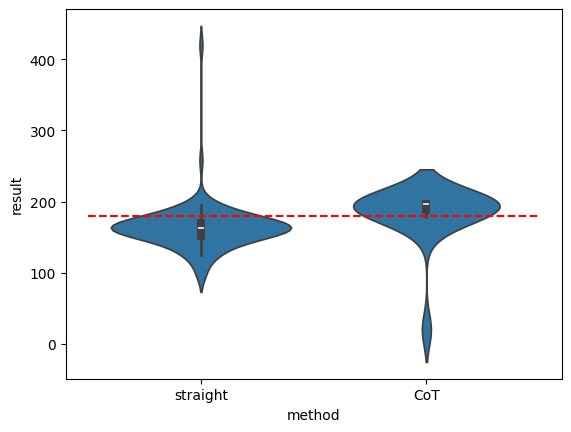

In [14]:
import seaborn as sns
sns.violinplot(data=df, x="method", y="result")
plt.hlines(179.5, *plt.xlim(), colors='r', linestyles='--')